In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd
from scipy import stats

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# 2015 Liston + Alpine3D SMB

In [2]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_Liston/output/grids/a3d_grids_2015.nc"
ds_l = xr.open_dataset(path)
n_trim = 15 # 15
ds_l = ds_l.isel(easting=slice(n_trim, -n_trim))
ds_l = ds_l.isel(northing=slice(n_trim, -n_trim))
l_smb = 1000 * (ds_l['swe'][-1,:,:] - ds_l['swe'][0,:,:])

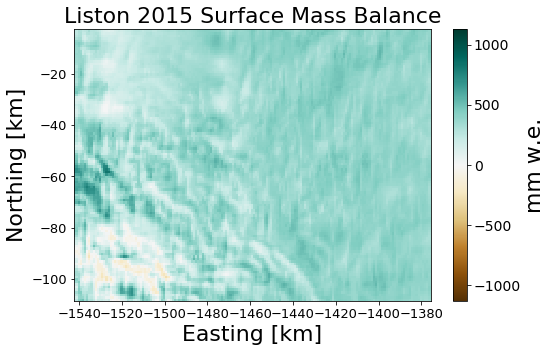

In [25]:
colormap = BrBG_11.mpl_colormap

plt.figure(figsize=(8, 5))
plt.pcolor(ds_l['easting']/1000, ds_l['northing']/1000, l_smb, cmap=colormap, vmin=-1130, vmax=1130, linewidth=0, rasterized=True)
# plt.pcolor(ds_l['easting']/1000, ds_l['northing']/1000, l_smb, cmap=colormap, rasterized=True)
cb = plt.colorbar()
cb.set_label("mm w.e.", fontsize=22)
cb.ax.tick_params(labelsize=14) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("Liston 2015 Surface Mass Balance", fontsize=22)
plt.savefig("images/liston_smb.pdf", format='pdf', dpi=100, bbox_inches='tight')

# 2015 WindNinja + Alpine3D SMB

In [4]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_WN/output/grids/a3d_grids_2015.nc"
ds_wn = xr.open_dataset(path)
n_trim = 15 # 15
ds_wn = ds_wn.isel(easting=slice(n_trim, -n_trim))
ds_wn = ds_wn.isel(northing=slice(n_trim, -n_trim))
wn_smb = 1000 * (ds_wn['swe'][-1,:,:] - ds_l['swe'][0,:,:])

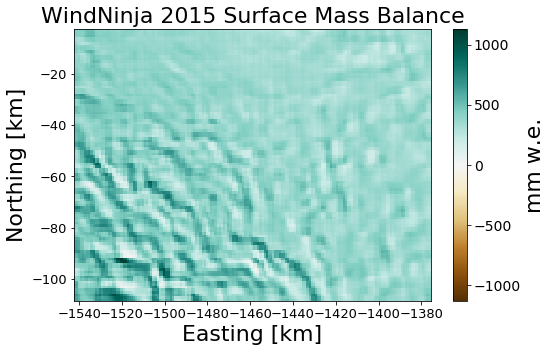

In [26]:
colormap = BrBG_11.mpl_colormap

plt.figure(figsize=(8, 5))
plt.pcolor(ds_wn['easting']/1000, ds_wn['northing']/1000, wn_smb, cmap=colormap, vmin=-1130, vmax=1130, linewidth=0, rasterized=True)
# plt.pcolor(ds_wn['easting']/1000, ds_wn['northing']/1000, wn_smb, cmap=colormap, rasterized=True)
cb = plt.colorbar()
cb.set_label("mm w.e.", fontsize=22)
cb.ax.tick_params(labelsize=14) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("WindNinja 2015 Surface Mass Balance", fontsize=22)
plt.savefig("images/wn_smb.pdf", format='pdf', dpi=100, bbox_inches='tight')

In [6]:
print(wn_smb.min().values)
print(l_smb.min().values)
print(wn_smb.max().values)
print(l_smb.max().values)

-32.096863
-284.66034
1129.0664
830.06287


# Transect

In [7]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

In [8]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

In [9]:
domain_left = ds_l['easting'].min()
domain_right = ds_l['easting'].max()
domain_bottom = ds_l['northing'].min()
domain_top = ds_l['northing'].max()

In [10]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [11]:
# Calculate seconds in each month in 2015
seconds = np.zeros(12); seconds[:] = np.nan
count = -1
for year in range(2015, 2015 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60

# Path
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Precipitation
sn = xr.open_mfdataset(data_path + "PRECSN_monthly_2015.nc", combine='nested', concat_dim='time')
ls = xr.open_mfdataset(data_path + "PRECLS_monthly_2015.nc", combine='nested', concat_dim='time')
cu = xr.open_mfdataset(data_path + "PRECCU_monthly_2015.nc", combine='nested', concat_dim='time')

# Evaporation 
evap = xr.open_mfdataset(data_path + "EVAP_monthly_2015.nc", combine='nested', concat_dim='time')

# SMB
M2_smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
M2_smb = M2_smb.mean(dim='month').mean(dim='time') * seconds.mean() * 12

tgt_lon = xr.DataArray(obs_lon, dims="points")
tgt_lat = xr.DataArray(obs_lat, dims="points")
M2_transect = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest')

In [12]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

Liston_transect =  l_smb.sel(northing=tgt_y, easting=tgt_x, method='nearest')
WN_transect =  wn_smb.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Indices to plot
ind0 = 660
indf = 2000
indices = np.arange(ind0, indf)

In [13]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

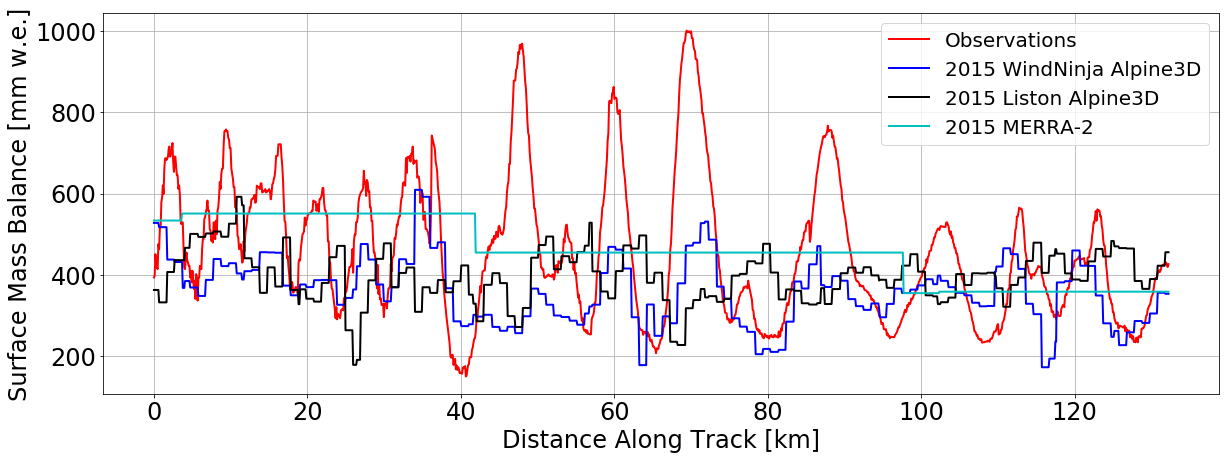

In [27]:
plt.figure(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=2)
plt.plot(dat, WN_transect[indices], 'b', label='2015 WindNinja Alpine3D', linewidth=2)
plt.plot(dat, Liston_transect[indices], 'k', label='2015 Liston Alpine3D', linewidth=2)
plt.plot(dat, M2_transect[indices], 'c', label='2015 MERRA-2', linewidth=2)
plt.grid()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("Surface Mass Balance [mm w.e.]", fontsize=24)
plt.xlabel("Distance Along Track [km]", fontsize=24)
plt.legend(fontsize=20)
plt.savefig('images/2015_transect.pdf', format='pdf', dpi=100)

In [15]:
M2_transect[indices].mean().values

array(459.24744, dtype=float32)

In [16]:
print(float(M2_transect[indices].mean().values))
print(float(Liston_transect[indices].mean()))
print(float(WN_transect[indices].mean()))

459.2474365234375
396.0479431152344
359.7598876953125


# Scatter plots

In [17]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [18]:
spacing = 10
obs_convulation = 1000 * np.convolve(obs_accumulation[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
M2_convulation = np.convolve(M2_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
WN_convulation = np.convolve(WN_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
Liston_convulation = np.convolve(Liston_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]

In [19]:
x_1_to_1 = [-9999, 9999]
y_1_to_1 = [-9999, 9999]

p = 1.371653206244972e-12
R^2 = 0.31742446004807756
RMSE = 175.3067283143243
Average Bias = 127.48394890551783
Linear Fit Slope = 0.2550399166360385


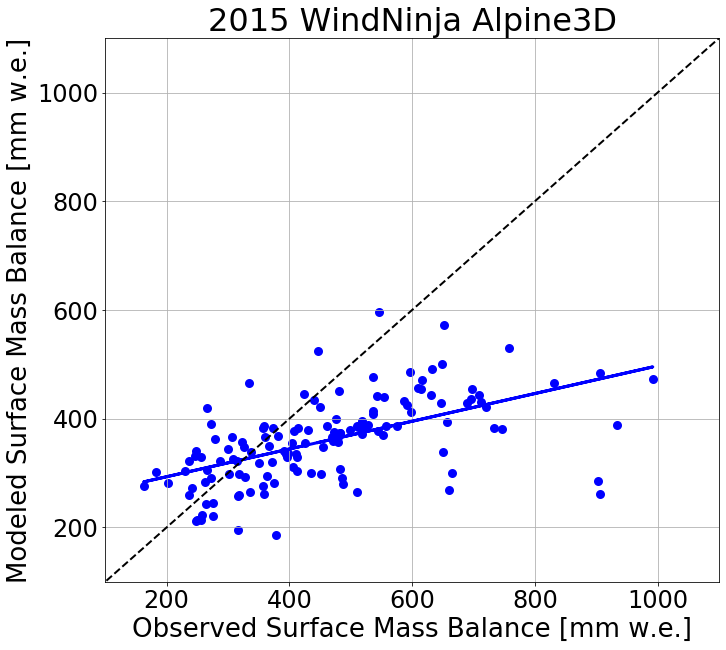

In [36]:
x = obs_convulation
y = WN_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(11,10))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.title("2015 WindNinja Alpine3D", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=26)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=26)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015_WN_Alpine3D_Scatter.pdf', format='pdf', dpi=100)

p = 0.00010675998673618962
R^2 = 0.10788846094090242
RMSE = 210.3627342522428
Average Bias = 159.15935106663648
Linear Fit Slope = -0.11548780092743009


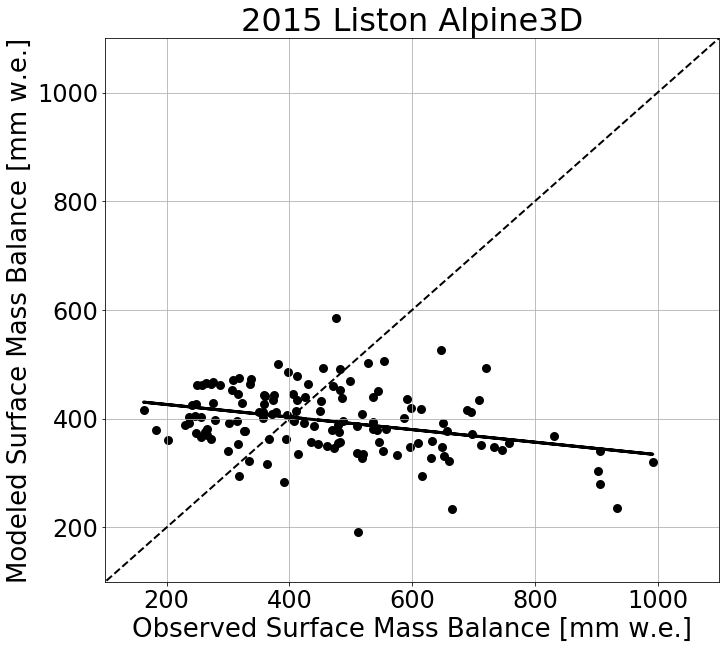

In [37]:
x = obs_convulation
y = Liston_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(11,10))
plt.scatter(x, y, c='k', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'k', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.title("2015 Liston Alpine3D", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=26)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=26)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015_Liston_Alpine3D_Scatter.pdf', format='pdf', dpi=100)

p = 0.0023085938855032
R^2 = 0.06818132986181667
RMSE = 168.3135173850795
Average Bias = 128.5096673538683
Linear Fit Slope = 0.1098718251955722


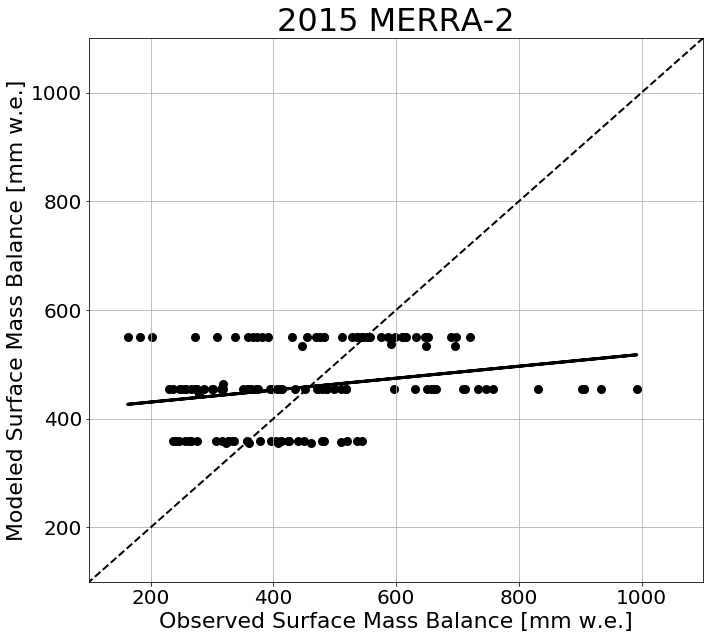

In [35]:
x = obs_convulation
y = M2_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(11,10))
plt.scatter(x, y, c='k', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'k', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("2015 MERRA-2", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015_Liston_Alpine3D_Scatter.pdf', format='pdf', dpi=100)